In [ ]:
#pip install git+https://github.com/compmonks/SOMPY.git
#pip install ipdb

In [ ]:
#pip install multiprocess

In [1]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

In [2]:
import os
import time
import numpy as np
import logging
import sompy



from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
%matplotlib inline

CACHEDIR=C:\Users\admin\.matplotlib
Using fontManager instance from C:\Users\admin\.matplotlib\fontlist-v310.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [3]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

In [4]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550,sg=0)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)

In [5]:
def train(inp, map_size, iterations, parallelism):
    print('training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

In [36]:
import worker

def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=100, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = worker.get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score

In [7]:
data_path = "data-1.json"

In [8]:
data = pd.read_json(data_path)

In [9]:
_preprocess(data)
data.head()

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages


In [10]:
data.tail()

,message
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages
9999,DEBUGProcessedoutofpackages


In [11]:
x = data.message.value_counts()
for i in x.keys():
    print(i, x[i])

DEBUGProcessedoutofpackages 9786
ThreadodcsserverINFOComposetypestatedoneComposedone 213
rootCMDusrlocalbinmonitorapachestatsshdevnull 1


In [12]:
w2vmodel = create(data, 100,3)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 3 word types from a corpus of 10000 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 3 unique words (100% of original 3, drops 0)
effective_min_count=1 leaves 10000 word corpus (100% of original 10000, drops 0)
deleting the raw counts dictionary of 3 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 379 word corpus (3.8% of prior 10000)
estimated required memory for 3 words and 100 dimensions: 3900 bytes
resetting layer weights
training model with 1 workers on 3 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10000 raw words (377 effective words) took 0.0s, 54021 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 35 : training on 10000 raw words (366 effective words) took 0.0s, 62983 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 36 : training on 10000 raw words (354 effective words) took 0.0s, 67268 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 37 : training on 10000 raw words (381 effective words) took 0.0s, 75613 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 38 : training on 10000 raw words (378 effective words) took 0.0s, 56327 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more thread

worker thread finished; awaiting finish of 0 more threads
EPOCH - 72 : training on 10000 raw words (376 effective words) took 0.0s, 76967 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 73 : training on 10000 raw words (395 effective words) took 0.0s, 66092 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 74 : training on 10000 raw words (349 effective words) took 0.0s, 115709 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 75 : training on 10000 raw words (381 effective words) took 0.0s, 74315 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 76 : training on 10000 raw words (366 effective words

EPOCH - 109 : training on 10000 raw words (354 effective words) took 0.0s, 65167 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 110 : training on 10000 raw words (403 effective words) took 0.0s, 73627 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 111 : training on 10000 raw words (384 effective words) took 0.0s, 71945 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 112 : training on 10000 raw words (365 effective words) took 0.0s, 56682 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 113 : training on 10000 raw words (400 effective words) took 0.0s, 78445 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 147 : training on 10000 raw words (401 effective words) took 0.0s, 85250 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 148 : training on 10000 raw words (364 effective words) took 0.0s, 58470 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 149 : training on 10000 raw words (361 effective words) took 0.0s, 76632 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 150 : training on 10000 raw words (400 effective words) took 0.0s, 77244 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 184 : training on 10000 raw words (378 effective words) took 0.0s, 77640 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 185 : training on 10000 raw words (383 effective words) took 0.0s, 73515 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 186 : training on 10000 raw words (416 effective words) took 0.0s, 75724 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 187 : training on 10000 raw words (373 effective words) took 0.0s, 73943 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 188 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 221 : training on 10000 raw words (394 effective words) took 0.0s, 89379 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 222 : training on 10000 raw words (386 effective words) took 0.0s, 75775 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 223 : training on 10000 raw words (407 effective words) took 0.0s, 87514 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 224 : training on 10000 raw words (355 effective words) took 0.0s, 58181 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 225 : training on 10000 raw words (360 effective w

EPOCH - 258 : training on 10000 raw words (378 effective words) took 0.0s, 80515 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10000 raw words (371 effective words) took 0.0s, 62397 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10000 raw words (370 effective words) took 0.0s, 64263 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10000 raw words (396 effective words) took 0.0s, 63842 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10000 raw words (397 effective words) took 0.0s, 69138 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 296 : training on 10000 raw words (380 effective words) took 0.0s, 69552 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 297 : training on 10000 raw words (382 effective words) took 0.0s, 81289 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 298 : training on 10000 raw words (383 effective words) took 0.0s, 73374 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 299 : training on 10000 raw words (379 effective words) took 0.0s, 74545 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 333 : training on 10000 raw words (370 effective words) took 0.0s, 75180 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 334 : training on 10000 raw words (389 effective words) took 0.0s, 99624 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 335 : training on 10000 raw words (412 effective words) took 0.0s, 92364 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 336 : training on 10000 raw words (358 effective words) took 0.0s, 71037 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 337 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 370 : training on 10000 raw words (348 effective words) took 0.0s, 59073 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 371 : training on 10000 raw words (353 effective words) took 0.0s, 102423 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 372 : training on 10000 raw words (393 effective words) took 0.0s, 71911 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 373 : training on 10000 raw words (379 effective words) took 0.0s, 81327 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 374 : training on 10000 raw words (370 effective 

EPOCH - 407 : training on 10000 raw words (372 effective words) took 0.0s, 98447 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 408 : training on 10000 raw words (383 effective words) took 0.0s, 77117 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 409 : training on 10000 raw words (379 effective words) took 0.0s, 72396 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 410 : training on 10000 raw words (375 effective words) took 0.0s, 85830 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 411 : training on 10000 raw words (385 effective words) took 0.0s, 60439 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 445 : training on 10000 raw words (378 effective words) took 0.0s, 118140 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 446 : training on 10000 raw words (396 effective words) took 0.0s, 72075 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 447 : training on 10000 raw words (376 effective words) took 0.0s, 75295 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 448 : training on 10000 raw words (394 effective words) took 0.0s, 115705 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more 

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 482 : training on 10000 raw words (370 effective words) took 0.0s, 81446 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 483 : training on 10000 raw words (387 effective words) took 0.0s, 68289 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 484 : training on 10000 raw words (412 effective words) took 0.0s, 75015 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 485 : training on 10000 raw words (387 effective words) took 0.0s, 76052 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 486 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10000 raw words (381 effective words) took 0.0s, 77320 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10000 raw words (351 effective words) took 0.0s, 102497 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10000 raw words (369 effective words) took 0.0s, 74092 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10000 raw words (398 effective words) took 0.0s, 95407 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10000 raw words (363 effective 

In [13]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = transformed_data[:,1:]

In [14]:
type(transformed_data) #numpy.ndarray
#transformed_data.shape #(10000, 100)

numpy.ndarray

In [15]:
#unique0, counts0 = np.unique(transformed_data, return_counts=True)
#dict(zip(unique0, counts0))

In [16]:
from sklearn.neighbors import LocalOutlierFactor
print(__doc__)

X=transformed_data
clf = LocalOutlierFactor(n_neighbors=300, metric='euclidean')
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

Automatically created module for IPython interactive environment


In [17]:
X_scores.shape

(10000,)

In [18]:
#type(y_pred)#numpy.ndarray
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{-1: 214, 1: 9786}

In [19]:
#Use PCA to extract key features and visualization 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 


scaler=preprocessing.StandardScaler().fit(X) 
X_transformed=scaler.transform(X) 

print("shape of train data before pca", X_transformed.shape)


N_components=2
Data_pca=PCA(n_components=N_components).fit(X_transformed)
X_pca=Data_pca.transform(X_transformed)

print("shape of train data after pca", X_pca.shape)

shape of train data before pca (10000, 100)
shape of train data after pca (10000, 2)


In [20]:
unique2, counts2 = np.unique(X_pca, return_counts=True)
dict(zip(unique2, counts2))

{-1.4760463341249643: 9786,
 -0.018320182123814907: 213,
 -0.0018339750718900508: 9786,
 10.889824428439198: 1,
 21.849478845998107: 1,
 67.76384789351347: 213}

In [21]:
print("variance explained", Data_pca.explained_variance_ratio_ )

variance explained [9.99522496e-01 4.77504130e-04]


In [22]:
y_pred_pca = clf.fit_predict(X_pca)
X_scores_pca = clf.negative_outlier_factor_


unique_pca, counts_pca = np.unique(y_pred_pca, return_counts=True)
dict(zip(unique_pca, counts_pca))

{-1: 214, 1: 9786}

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono

findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Corbel' (corbell.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Vladimir Script' (VLADIMIR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft JhengHei' (msjhl.ttc) normal normal light normal>) = 10.24
findfont: score(<Font 'Marlett' (marlett.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bernard MT Condensed' (BERNHC.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Cambria' (cambriab.

findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (ARIALN.TTF) normal normal 400 condensed>) = 6.613636363636363
findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (courbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (arialbd.ttf) normal normal 700 normal>) = 6.698636363636363
findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 4

findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal light normal>) = 11.24
findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Microsoft YaHei' (msyhbd.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Calligraphy' (LCALLIG.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoe

findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\Users\\admin\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif' (DejaV

findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Calisto MT' (CALISTBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Corbel' (corbell.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Vladimir Script' (VLADIMIR.TTF) normal n

findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal demi condensed>) = 10.44
findfont: score(<Font 'Centaur' (CENTAUR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILI____.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (ARIALN.TTF) normal normal 400 condensed>) = 6.613636363636363
findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal 

findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Leelawadee UI' (LeelUIsl.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT Ext Condensed Bold' (GLSNECB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal 700 normal>) = 11.335
findfont: 

findfont: score(<Font 'Kristen ITC' (ITCKRIST.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal 700 normal>) = 3.9713636363636367
findfont: score(<Font 'Arial' (ariblk.ttf) normal normal black normal>) = 6.888636363636364
findfont: score(<Font 'Times New Roman' (times.ttf) normal normal roman normal>) = 10.145
findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Franklin Gothic Demi' (FRADMIT.TTF) italic normal demi normal>) = 11.24
findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '

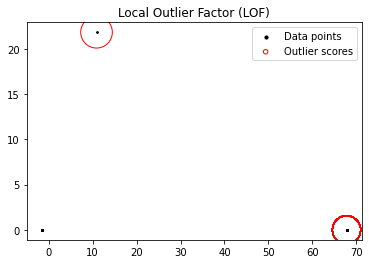

In [23]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores_pca.max() - X_scores_pca) / (X_scores_pca.max() - X_scores_pca.min())
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')

legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [24]:
map_size = 16
model = train(transformed_data, map_size, 0, 2)

 Training...
 random_initialization took: 0.003000 seconds
 Rough training...
 radius_ini: 6.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.050000, quantization error: 33.970113

 epoch: 2 ---> elapsed time:  0.047000, quantization error: 1.259820



training dataset is of size {inp.shape[0]}


 epoch: 3 ---> elapsed time:  0.049000, quantization error: 0.117026

 epoch: 4 ---> elapsed time:  0.051000, quantization error: 0.104047

 epoch: 5 ---> elapsed time:  0.050000, quantization error: 0.093979

 epoch: 6 ---> elapsed time:  0.050000, quantization error: 0.084629

 epoch: 7 ---> elapsed time:  0.050000, quantization error: 0.075980

 epoch: 8 ---> elapsed time:  0.052000, quantization error: 0.068010

 epoch: 9 ---> elapsed time:  0.050000, quantization error: 0.060695

 epoch: 10 ---> elapsed time:  0.050000, quantization error: 0.054006

 epoch: 11 ---> elapsed time:  0.048000, quantization error: 0.047917

 epoch: 12 ---> elapsed time:  0.050000, quantization error: 0.042394

 epoch: 13 ---> elapsed time:  0.050000, quantization error: 0.037408

 epoch: 14 ---> elapsed time:  0.049000, quantization error: 0.032915

 epoch: 15 ---> elapsed time:  0.046000, quantization error: 0.028600

 epoch: 16 ---> elapsed time:  0.049000, quantization error: 0.025014

 epoch: 17 --

C:\Users\admin\anaconda3\lib\site-packages\sompy\visualization\hitmap.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


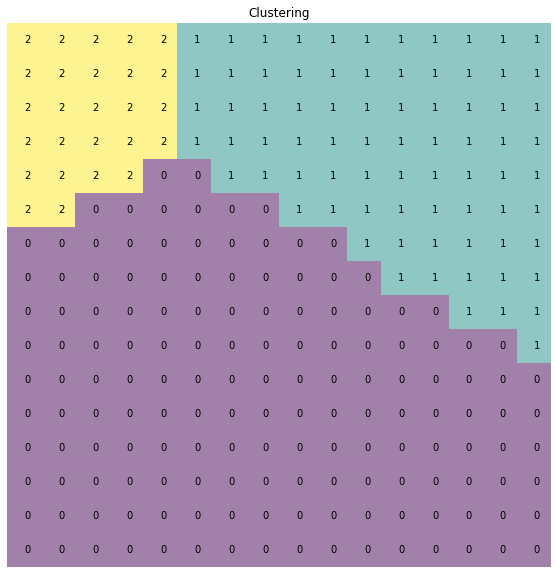

In [25]:
from sompy.visualization.hitmap import HitMapView
model.cluster(3)
hits  = HitMapView(10,10,"Clustering",text_size=7)
a=hits.show(model)

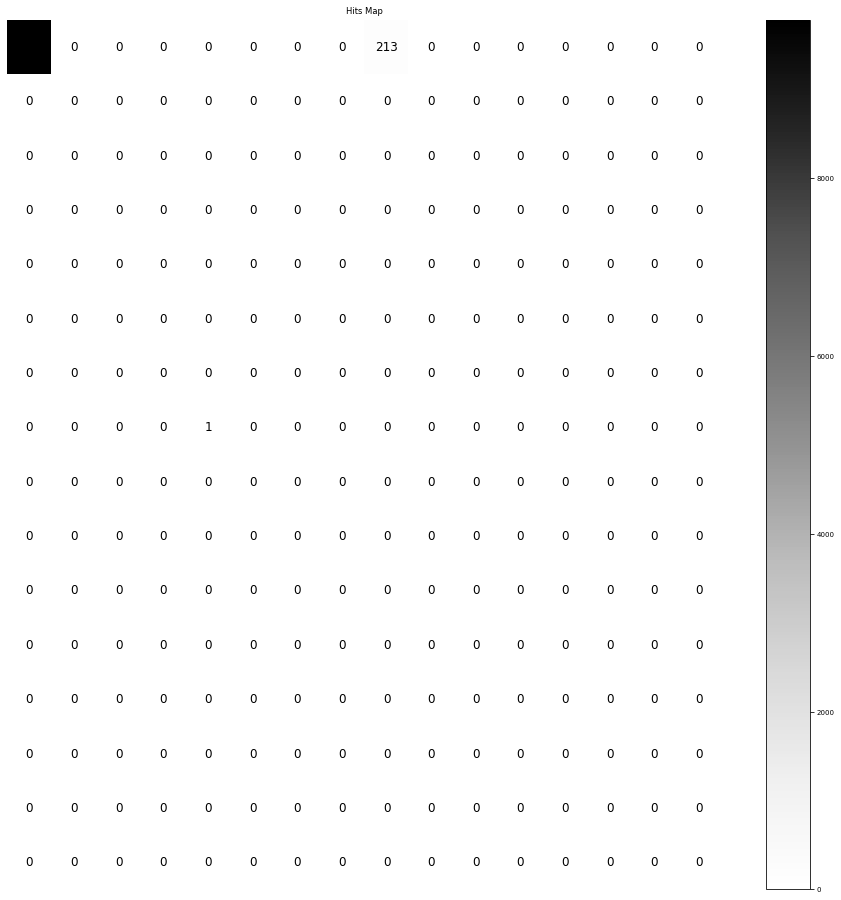

In [26]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [27]:
m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

In [30]:
import worker
distances = worker.get_anomaly_score(transformed_data, 8, m)

print(max(distances))
print(min(distances))
print(np.mean(distances))
print(np.std(distances))

0.20573478820977897
0.1858901941095482
0.18882263308269776
0.0024950939431575394


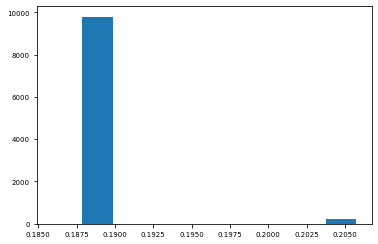

In [31]:
plt.hist(distances)
plt.show()

In [32]:
threshold = 3*np.std(distances) + np.mean(distances)
threshold

0.19630791491217037

In [33]:
count = 0
for i, j in enumerate(distances):
    if j > threshold:
        print(j, data.loc[i])
        count += 1
print(count)

0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6722, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6723, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6724, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6725, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6726, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6727, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6728, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6729, dtype: object
0.20573478820977897 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6730, dtype: object
0.20573478820977897 message    Thread

In [34]:
data.message.value_counts()

DEBUGProcessedoutofpackages                            9786
ThreadodcsserverINFOComposetypestatedoneComposedone     213
rootCMDusrlocalbinmonitorapachestatsshdevnull             1
Name: message, dtype: int64

In [37]:
infer(w2vmodel,m,'rootCMDusrlocalbinmonitorapachestatsshdevnull', data,threshold)

(0, [0.18589020338315543])

In [38]:
infer(w2vmodel,m,'DEBUGProcessedoutofpackages', data,threshold)

(0, [0.18845477218051676])

In [39]:
infer(w2vmodel,m,'ThreadodcsserverINFOComposetypestatedoneComposedone ', data,threshold)

(1, [0.20573480462320248])

In [40]:
infer(w2vmodel,m,'FSKSDNKSDNKSfdhfhfdhfdhfdhfdhfd  hfhf dlksfljscomLDN', data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 246331 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 131826 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 146032 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 127028 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 125004 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 146536 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 122473 effective words/s
worker thread finished; awaiting finish of 0 more threads


EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 136815 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 112016 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 130791 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 139469 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 131635 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 104636 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effec

EPOCH - 153 : training on 10001 raw words (361 effective words) took 0.0s, 142283 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 249051 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 120142 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 116301 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 137618 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 148211 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effec

EPOCH - 205 : training on 10001 raw words (431 effective words) took 0.0s, 140044 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 130142 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 132094 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 127148 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 118811 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 111143 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effec

EPOCH - 257 : training on 10001 raw words (373 effective words) took 0.0s, 129240 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 133900 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 349547 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 311466 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 137364 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 84425 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effect

EPOCH - 309 : training on 10001 raw words (420 effective words) took 0.0s, 141139 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 310 : training on 10001 raw words (366 effective words) took 0.0s, 114132 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 132683 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 162865 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 118146 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 122014 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effec

EPOCH - 361 : training on 10001 raw words (407 effective words) took 0.0s, 147224 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 362 : training on 10001 raw words (390 effective words) took 0.0s, 314973 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 129127 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 135587 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 121090 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 128029 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effec

EPOCH - 413 : training on 10001 raw words (421 effective words) took 0.0s, 153459 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 414 : training on 10001 raw words (404 effective words) took 0.0s, 139027 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 415 : training on 10001 raw words (386 effective words) took 0.0s, 112763 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 125929 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 130185 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 115691 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effec

EPOCH - 465 : training on 10001 raw words (376 effective words) took 0.0s, 122440 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 466 : training on 10001 raw words (407 effective words) took 0.0s, 122186 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 467 : training on 10001 raw words (411 effective words) took 0.0s, 147635 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 106488 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 115180 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 115651 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effec

EPOCH - 517 : training on 10001 raw words (383 effective words) took 0.0s, 133463 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 518 : training on 10001 raw words (388 effective words) took 0.0s, 115284 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10001 raw words (392 effective words) took 0.0s, 153107 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10001 raw words (400 effective words) took 0.0s, 146891 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 127550 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 133549 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effec

(1, [0.3250521490408178])

In [41]:
infer(w2vmodel,m,'this is not a log message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 356742 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 121567 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 157171 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 178155 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 171681 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 172479 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 118196 effective words/s
worker thread finished; awaiting finish of 0 more threads


EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 134543 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 165268 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 166178 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 166341 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 119878 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 153804 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effec

EPOCH - 153 : training on 10001 raw words (361 effective words) took 0.0s, 143169 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 156169 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 156318 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 158942 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 169893 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 153512 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effec

EPOCH - 205 : training on 10001 raw words (431 effective words) took 0.0s, 168861 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 146306 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 160816 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 148115 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 161326 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 114040 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effec

EPOCH - 257 : training on 10001 raw words (373 effective words) took 0.0s, 118994 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 140798 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 147578 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 164067 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 156482 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 147231 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effec

EPOCH - 309 : training on 10001 raw words (420 effective words) took 0.0s, 162093 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 310 : training on 10001 raw words (366 effective words) took 0.0s, 121716 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 146389 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 165707 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 104062 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 150441 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effec

EPOCH - 361 : training on 10001 raw words (407 effective words) took 0.0s, 128052 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 362 : training on 10001 raw words (390 effective words) took 0.0s, 135851 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 126136 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 113871 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 107425 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 146695 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effec

EPOCH - 413 : training on 10001 raw words (421 effective words) took 0.0s, 149625 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 414 : training on 10001 raw words (404 effective words) took 0.0s, 129222 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 415 : training on 10001 raw words (386 effective words) took 0.0s, 133260 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 142623 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 107421 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 121471 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effec

EPOCH - 465 : training on 10001 raw words (376 effective words) took 0.0s, 135145 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 466 : training on 10001 raw words (407 effective words) took 0.0s, 111654 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 467 : training on 10001 raw words (411 effective words) took 0.0s, 145884 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 117449 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 132279 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 121739 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effec

EPOCH - 517 : training on 10001 raw words (383 effective words) took 0.0s, 139761 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 518 : training on 10001 raw words (388 effective words) took 0.0s, 141487 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10001 raw words (392 effective words) took 0.0s, 157785 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10001 raw words (400 effective words) took 0.0s, 152724 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 156044 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 165076 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effec

(1, [0.32268962984177585])

In [42]:
infer(w2vmodel,m,'message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 342103 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 105100 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 137502 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 145145 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 135649 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 135503 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 127931 effective words/s
worker thread finished; awaiting finish of 0 more threads


EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 101692 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 149587 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 138250 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 116082 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 116729 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 130471 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effec

EPOCH - 153 : training on 10001 raw words (361 effective words) took 0.0s, 127229 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 114024 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 130409 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 124612 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 133959 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 125504 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effec

EPOCH - 205 : training on 10001 raw words (431 effective words) took 0.0s, 148826 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 126251 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 119118 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 137571 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 141337 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 108306 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effec

EPOCH - 257 : training on 10001 raw words (373 effective words) took 0.0s, 129222 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 131611 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 123974 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 115362 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 133479 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 117876 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effec

EPOCH - 309 : training on 10001 raw words (420 effective words) took 0.0s, 127834 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 310 : training on 10001 raw words (366 effective words) took 0.0s, 129750 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 141496 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 114508 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 129069 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 285288 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effec

EPOCH - 361 : training on 10001 raw words (407 effective words) took 0.0s, 166858 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 362 : training on 10001 raw words (390 effective words) took 0.0s, 139360 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 280789 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 139540 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 156557 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 130855 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effec

EPOCH - 413 : training on 10001 raw words (421 effective words) took 0.0s, 137076 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 414 : training on 10001 raw words (404 effective words) took 0.0s, 127933 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 415 : training on 10001 raw words (386 effective words) took 0.0s, 120670 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 129036 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 128267 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 130525 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effec

EPOCH - 465 : training on 10001 raw words (376 effective words) took 0.0s, 114206 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 466 : training on 10001 raw words (407 effective words) took 0.0s, 122487 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 467 : training on 10001 raw words (411 effective words) took 0.0s, 152777 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 116700 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 144333 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 144605 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effec

EPOCH - 517 : training on 10001 raw words (383 effective words) took 0.0s, 140623 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 518 : training on 10001 raw words (388 effective words) took 0.0s, 128570 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10001 raw words (392 effective words) took 0.0s, 314581 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10001 raw words (400 effective words) took 0.0s, 142258 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 152273 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 107656 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effec

(1, [0.3212227872561285])